In [1]:
import os
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import time, datetime
import copy
import numpy as np
from torch.optim import lr_scheduler
from torchvision import datasets
from resnet_pytorch import ResNet 
import random
from PIL import Image
from torch.nn import functional as F

# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트
font_name = fm.FontProperties(fname="/usr/share/fonts/nanum/NanumGothicExtraBold.ttf").get_name()
plt.rc('font', family=font_name)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
batch_size = 32
input_path = "/home/piai/Documents/Hanja_crop/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [3]:
test_transform = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        normalize
                                    ])
test_dataset = datasets.ImageFolder(input_path + 'test', test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [4]:
classes = test_dataset.classes
len(classes)

4893

In [5]:
model = ResNet.from_pretrained("resnet101", num_classes=len(classes))
model.to(device)

model.load_state_dict(torch.load('./models/runs/exp1/best_weights.pth'))

Loaded pretrained weights for resnet101.


<All keys matched successfully>

## Test the Model

In [6]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += torch.sum(predicted == labels.data)
        #print(labels)
        #print(predicted)
        # correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

/home/piai/anaconda3/envs/posco14/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy of the model on the test images: 94.9151840209961 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


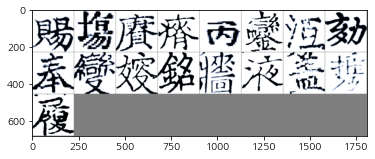

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# # 학습용 이미지를 무작위로 가져오기
# dataiter = iter(dataloaders['train'])
# images, labels = dataiter.next()
import torchvision
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

In [8]:
[classes[labels[j]] for j in range(17)]

['1736',
 '2918',
 '3514',
 '2865',
 '1152',
 '4539',
 '4624',
 '3925',
 '457',
 '2656',
 '526',
 '4644',
 '629',
 '1295',
 '227',
 '1677',
 '2576']

## Image 출력

In [9]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [10]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [11]:
images, labels, probs = get_predictions(model, test_loader)
pred_labels = torch.argmax(probs, 1)

In [12]:
img_list = random.sample(range(len(images)), 30)
img_list[:5]

[23098, 8417, 9375, 13715, 11463]

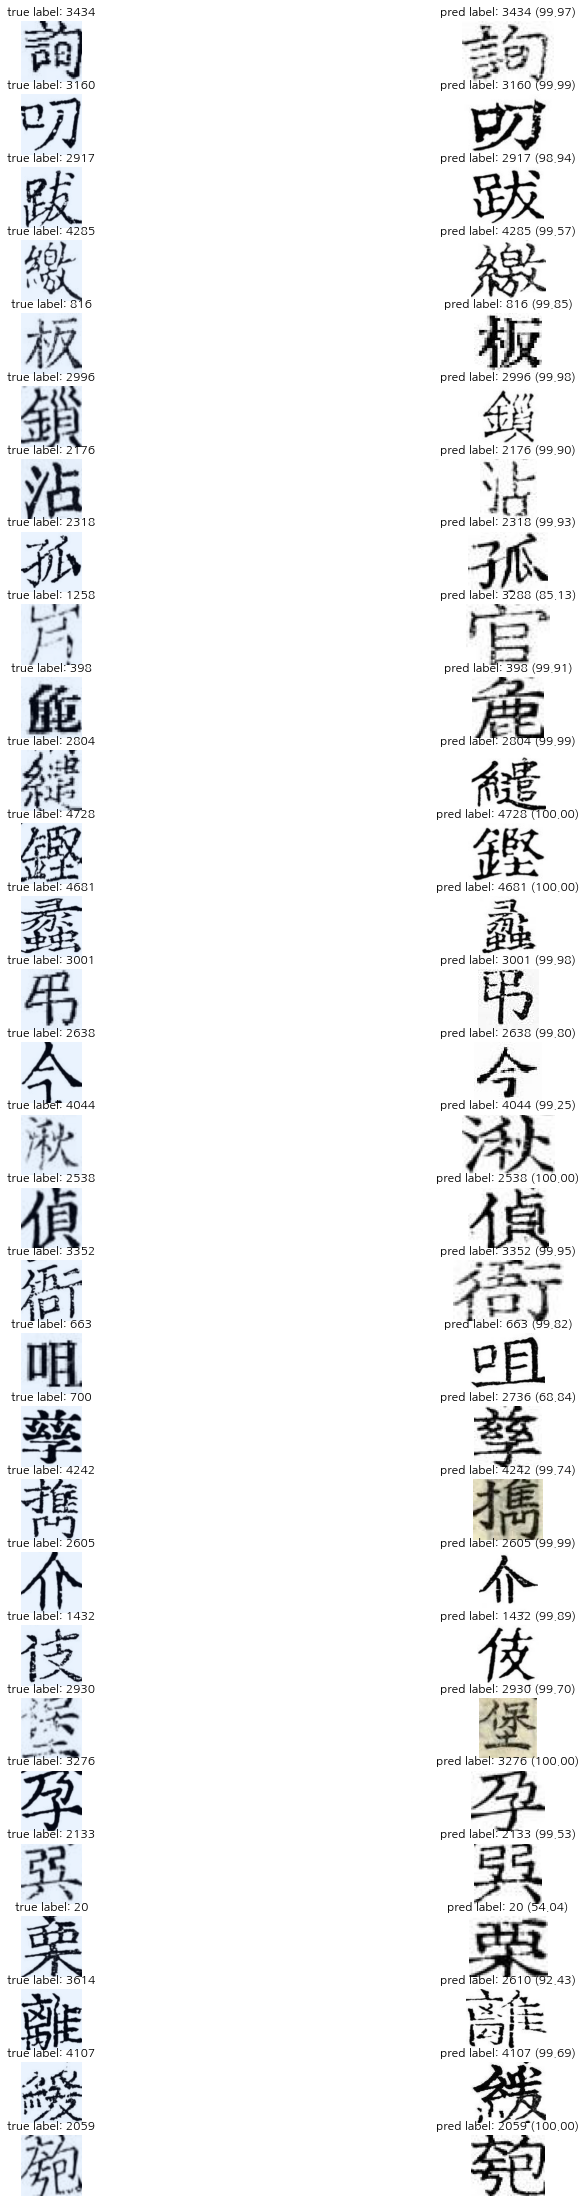

In [14]:
fig, axs = plt.subplots(len(img_list), 2, figsize=(15, 40))

j = 0
for idx in img_list:
    ax1 = axs[j, 0]
    ax2 = axs[j, 1]

    
    true_label = classes[labels[idx]]
    pred_prob, pred_label = max(probs[idx]), classes[pred_labels[idx]]

    img1 = images[idx].permute(1, 2, 0)    
    if normalize:
        img1 = normalize_image(img1)
        
    img_path2 = '/home/piai/Documents/Hanja_crop/train/{}/'.format(pred_label)
    img_name2 = img_path2 + os.listdir(img_path2)[0]
    img2 = Image.open(img_name2).convert('RGB')
    img2  = np.array(img2)

        
    ax1.imshow(img1)
    ax1.set_title(f'true label: {true_label}')
    
    ax2.imshow(img2)
    ax2.set_title(f'pred label: {pred_label} ({pred_prob*100:.2f})')
    
    
    ax1.axis('off')
    ax2.axis('off')
    j+=1